In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model input
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pre-trained models
])

In [3]:
!unzip -qq ./chip_data.zip -d data

In [4]:
# Load dataset from a folder (structured as: dataset/class_name/images)
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [5]:
# Display some input images
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

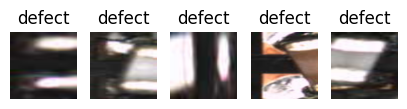

In [6]:
# Show sample images from the training dataset
show_sample_images(train_dataset)

In [7]:
# Get the total number of samples in the training dataset
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [8]:
# Get the total number of samples in the testing dataset
print(f"Total number of testing samples: {len(test_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = test_dataset[0]
print(f"Shape of the first image: {first_image.shape}")


Total number of testing samples: 121
Shape of the first image: torch.Size([3, 224, 224])


In [9]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
## Step 2: Load Pretrained Model and Modify for Transfer Learning
# Load a pre-trained VGG19 model
# write your code here
model = models.vgg19(pretrained=True)


# Modify the final fully connected layer to match the dataset classes
# Write your code here
in_features=model.classifier[-1].in_features
num_classes = len(train_dataset.classes)
model.classifier[-1] = nn.Linear(in_features, 1)





/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 74.2MB/s]


In [11]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [13]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [15]:
# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

In [16]:
# Include the Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [24]:
#Train the model
def train_model(model, train_loader, test_loader, num_epochs=50):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # Ensure proper shape for BCEWithLogitsLoss
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name:Sakthivel B")
    print("Register Number:212222040141")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [18]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Epoch [1/15], Train Loss: 0.0005, Validation Loss: 0.2800
Epoch [2/15], Train Loss: 0.0085, Validation Loss: 0.1117
Epoch [3/15], Train Loss: 0.0065, Validation Loss: 0.1514
Epoch [4/15], Train Loss: 0.0188, Validation Loss: 0.1896
Epoch [5/15], Train Loss: 0.0000, Validation Loss: 0.3223
Epoch [6/15], Train Loss: 0.0946, Validation Loss: 0.9363
Epoch [7/15], Train Loss: 0.0308, Validation Loss: 0.3587
Epoch [8/15], Train Loss: 0.0013, Validation Loss: 1.4259
Epoch [9/15], Train Loss: 0.0044, Validation Loss: 1.1079
Epoch [10/15], Train Loss: 0.0001, Validation Loss: 0.6084
Epoch [11/15], Train Loss: 0.4398, Validation Loss: 0.7263
Epoch [12/15], Train Loss: 0.3158, Validation Loss: 1.4948
Epoch [13/15], Train Loss: 0.5257, Validation Loss: 1.0626
Epoch [14/15], Train Loss: 0.1935, Validation Loss: 3.6521
Epoch [15/15], Train Loss: 0.9514, Validation Loss: 0.8800
Name:Sakthivel B
Register Number:212222040141


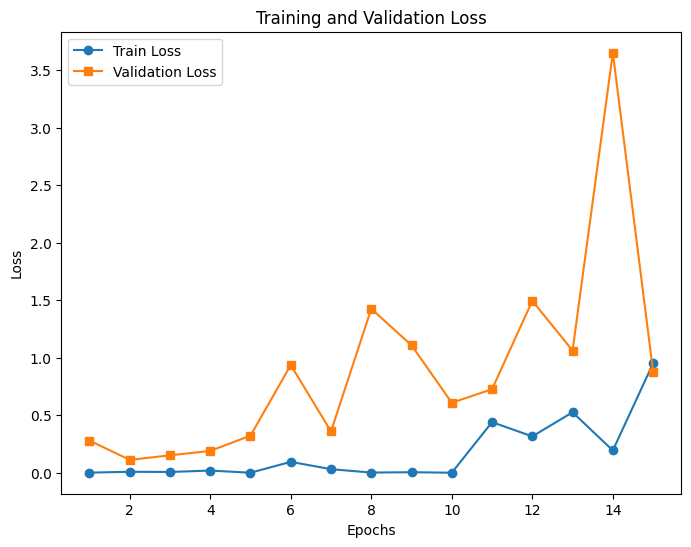

In [25]:
# Train the model
# Write your code here

train_model(model, train_loader, test_loader, num_epochs=15)




In [26]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # Ensure shape [batch_size, 1]

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).int()

            total += labels.size(0)
            correct += (predicted == labels.int()).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy().astype(int))

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    print("Name:Sakthivel B")
    print("Register Number:212222040141      ")
    class_names = ['Negative', 'Positive']  # You can rename as needed
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name:Sakthivel B")
    print("Register Number:212222040141")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

Test Accuracy: 0.9504
Name:Sakthivel B
Register Number:212222040141      


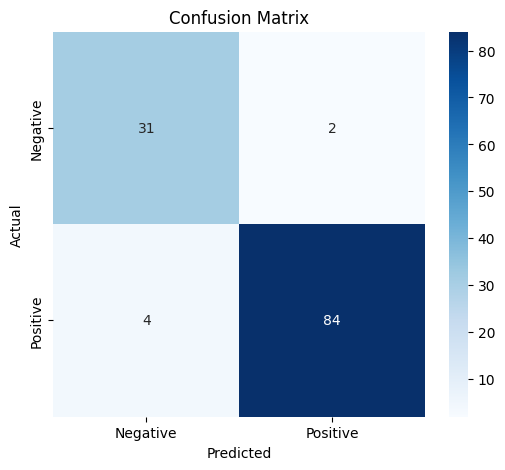

Name:Sakthivel B
Register Number:212222040141
Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.94      0.91        33
    Positive       0.98      0.95      0.97        88

    accuracy                           0.95       121
   macro avg       0.93      0.95      0.94       121
weighted avg       0.95      0.95      0.95       121



In [27]:
# Evaluate the model
# write your code here
test_model(model, test_loader)

In [28]:
## Step 5: Predict on a Single Image and Display It
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        # The image is already a tensor, just add batch dimension and send to device
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    class_names = dataset.classes  # Get class labels

    # Display the image
    # Need to convert the image back to PIL format for display
    image_to_display = transforms.ToPILImage()(image)
    print("Name:Sakthivel B")
    print("Register Number:212222040141 ")
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()

Name:Sakthivel B
Register Number:212222040141 


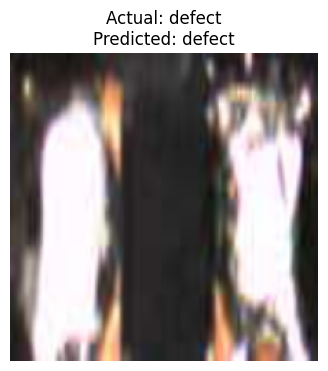

In [29]:
# Example Prediction
predict_image(model, image_index=22, dataset=test_dataset)

Name:Sakthivel B
Register Number:212222040141 


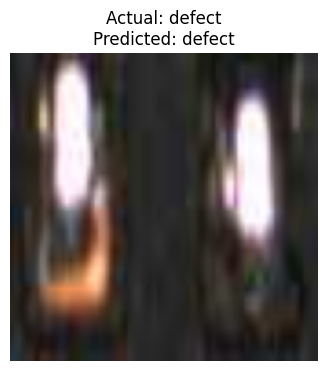

In [30]:
#Example Prediction
predict_image(model, image_index=25, dataset=test_dataset)